# Whole Human Brain 10x RNA-seq gene expression data (part 2)

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20240330'
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.cache._manifest_file_names = abc_cache.cache.list_all_downloaded_manifests()
abc_cache.load_manifest(f'releases/{version}/manifest.json')
abc_cache.current_manifest

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:608: UserWarning: The manifest version recorded as last used for this cache -- releases/20240330/manifest.json-- is not a valid manifest for this dataset. Loading latest version -- releases/20231215/manifest.json -- instead.
  warnings.warn(msg, UserWarning)
/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:640: OutdatedManifestWarning: You are loading
releases/20231215/manifest.json
which is newer than the most recent manifest file you have previously been working with
releases/20240330/manifest.json
It is possible that some data files have changed between these two data releases, which will force you to re-download those data files (currently downloaded files will not be overwritten). To continue using releases/20240330/manifest.json, run
type.load_manifest('releases/20240330/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


'releases/20240330/manifest.json'

Create the expanded cell metadata as was done previously in part 1 of this tutorial.. Examples of creating this table are presented in part 1.

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))

# Load the cluster memembership metadata and combine the data with the cell data.
membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[term_sets['name']] # order columns
cluster_details.fillna('Other', inplace=True)

cluster_details.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[term_sets['name']]
cluster_colors.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors

roi = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='region_of_interest_structure_map')
roi.set_index('region_of_interest_label', inplace=True)
roi.rename(columns={'color_hex_triplet': 'region_of_interest_color'},
           inplace=True)

del membership
del term_sets

cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(roi[['region_of_interest_color']], on='region_of_interest_label')

del cluster_details
del cluster_colors
del roi

cell_extended.head(5)

Number of cells =  3369219


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,donor_label,donor_sex,dataset_label,...,anatomical_division_label,subcluster,cluster,supercluster,neurotransmitter,subcluster_color,cluster_color,supercluster_color,neurotransmitter_color,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
10X386_2:CATGGATTCTCGACGG,CATGGATTCTCGACGG,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X383_5:TCTTGCGGTGAATTGA,TCTTGCGGTGAATTGA,10X383_5,LKTX_210818_02_E01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.94,10Xv3,H19.30.002,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X386_2:CTCATCGGTCGAGCAA,CTCATCGGTCGAGCAA,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_17,URL_312,Upper rhombic lip,VGLUT1,#C85E40,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X378_8:TTGGATGAGACAAGCC,TTGGATGAGACAAGCC,10X378_8,LKTX_210809_01_H01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.93,10Xv3,H19.30.002,M,WHB-10Xv3,...,Pons,URL_312_18,URL_312,Upper rhombic lip,VGLUT1,#61C1C2,#97B8C8,#80BAED,#2BDFD1,#517DBE
10X387_7:TGAACGTAGTATTCCG,TGAACGTAGTATTCCG,10X387_7,LKTX_210825_02_G01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_16,URL_312,Upper rhombic lip,VGLUT1,#45328F,#97B8C8,#80BAED,#2BDFD1,#5D6CB2


### Single cell transcriptomes

The ~3 million cell dataset of WHB has been divided into 2 expression matrices of Neurons and Nonneurons. Each matrix file is formatted as an annadata h5ad file with minimal metadata. 

Below we show some interactions with data from the 10X expression matricies in the WHB dataset. For a deeper dive into access specific gene data from the expression matricies, take a look at ``general_acessing_10x_snRNASeq_tutorial.ipynb``. Below we will use a combination of precomputed metadata from these matricies to look at there expression both in relation to different neurotransmitters and locations across the brain.

First, we list the available metadata in the WHB-10Xv3 dataset again. The two files we will be using in this tutorial are the ``gene`` metadata and the ``example_genes_all_cells_expression`` table.

In [4]:
abc_cache.list_metadata_files('WHB-10Xv3')

['anatomical_division_structure_map',
 'cell_metadata',
 'donor',
 'example_genes_all_cells_expression',
 'gene',
 'region_of_interest_structure_map']

The table below holds metadata for all genes sequenced in the dataset.

In [5]:
gene = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  59357


,gene_symbol,biotype,name
gene_identifier,,,
ENSG00000000003,TSPAN6,protein_coding,tetraspanin 6
ENSG00000000005,TNMD,protein_coding,tenomodulin
ENSG00000000419,DPM1,protein_coding,dolichyl-phosphate mannosyltransferase subunit...
ENSG00000000457,SCYL3,protein_coding,SCY1 like pseudokinase 3
ENSG00000000460,C1orf112,protein_coding,chromosome 1 open reading frame 112


We'll skip accessing these data from the expression matricies specifically for now, however, users can learn how to access specific genes from the release expression matricies can be found in the general_acessing_10x_snRNASeq_tutorial.ipynb notebook.

The precomputed table below contains expressions for the genes CUX2, LAMP5, PLVAP, THEMIS, ROBB for all cells across the the WHB dataset. We then join this with our previous created cell_extended pandas DataFrame from this tutorial.


In [6]:
example_cells_with_genes = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='example_genes_all_cells_expression'
).set_index('cell_label')
example_cells_with_genes.head()

,CUX2,LAMP5,PLVAP,THEMIS,RORB
cell_label,,,,,
10X386_2:CATGGATTCTCGACGG,0.0,0.0,0.0,0.0,0.0
10X383_5:TCTTGCGGTGAATTGA,0.0,0.0,0.0,0.0,0.0
10X386_2:CTCATCGGTCGAGCAA,0.0,0.0,0.0,0.0,0.0
10X378_8:TTGGATGAGACAAGCC,0.0,0.0,0.0,0.0,0.0
10X387_7:TGAACGTAGTATTCCG,0.0,0.0,0.0,0.0,0.0


In [7]:
cell_extended_with_genes = cell_extended.join(example_cells_with_genes)

## Example use cases

**NEED NEUROSCIENCE CONTEXT FOR THESE GENES***

In this section, we show a use case with the example genes CUX2, LAMP5, PLVAP, THEMIS, ROBB. 

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

In [8]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of selected genes in the whole brain

We create a heatmap showing the relation between various neuotransmitter and spatial properties vs the genes we've loaded.

In [9]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=6)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

Below, we plot the expression of the genes selected in five genes. We show the genes vs neurotransmitter type/idendity. 

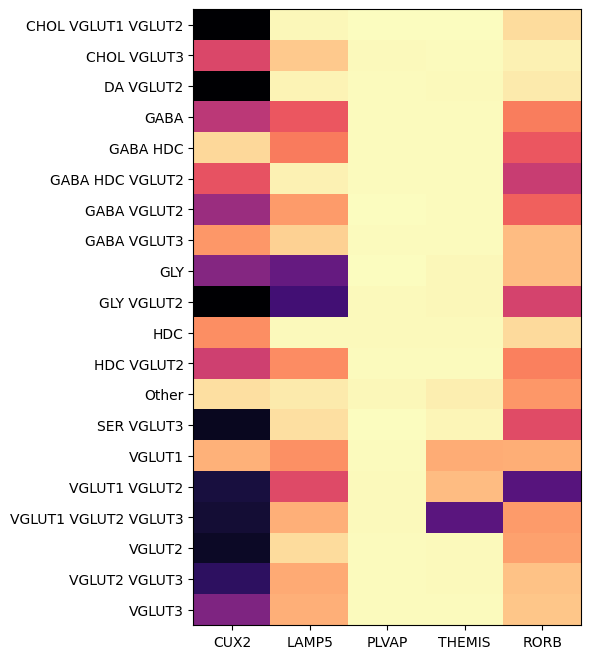

In [10]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'neurotransmitter')
res = plot_heatmap(agg, 5, 8)

By anatomical division label where groupping expression by dissection region of interest shows that each of these genes have distinct spatial patterns.

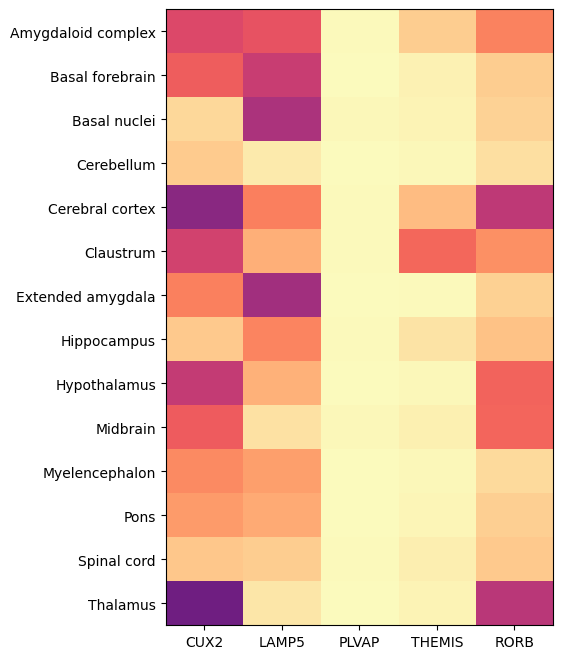

In [11]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'anatomical_division_label')
res = plot_heatmap(agg, 5, 8)

And finally by supercluster.

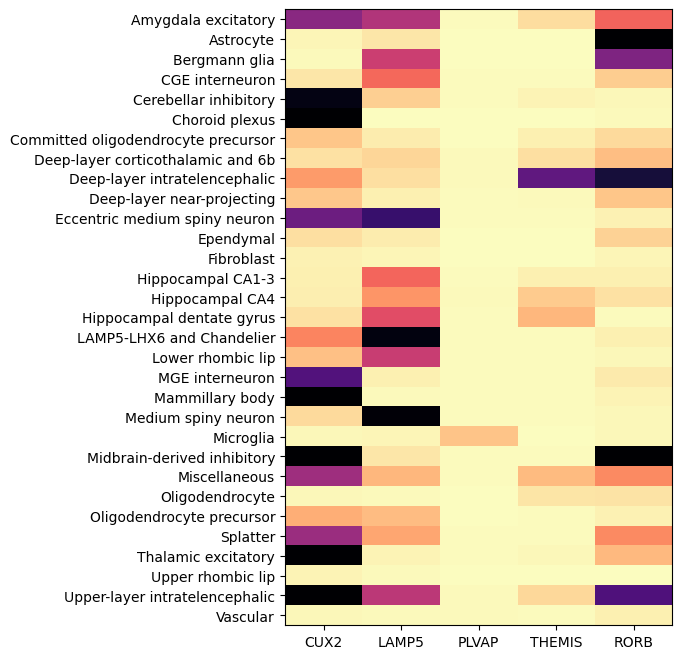

In [12]:
agg = aggregate_by_metadata(cell_extended_with_genes, example_cells_with_genes.columns, 'supercluster')
res = plot_heatmap(agg, 5, 8)

We can also visualize the relationship these genes and their spatial location by plotting their expression on the UMAP using the identified superclusters.

In [13]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [14]:
neurons_subsampled = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'WHB-10Xv3-Neurons'][::10]
non_neurons_subsampled = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'WHB-10Xv3-Nonneurons'][::10]

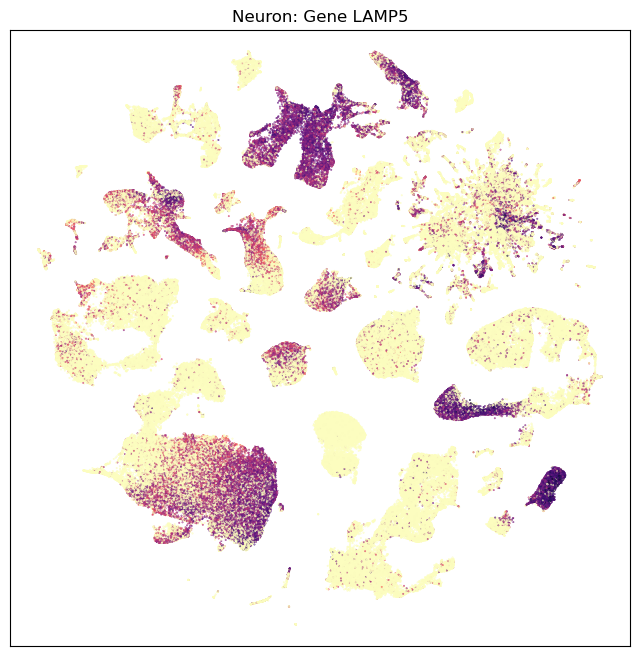

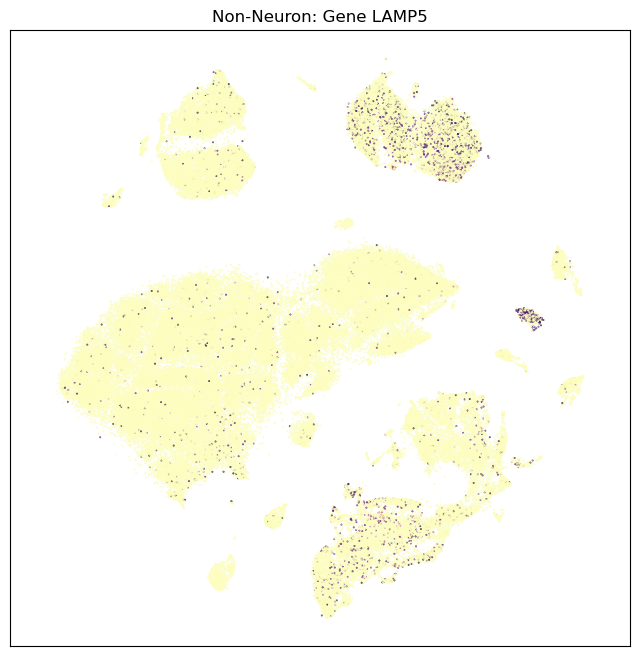

In [15]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['LAMP5'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene LAMP5")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['LAMP5'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene LAMP5")

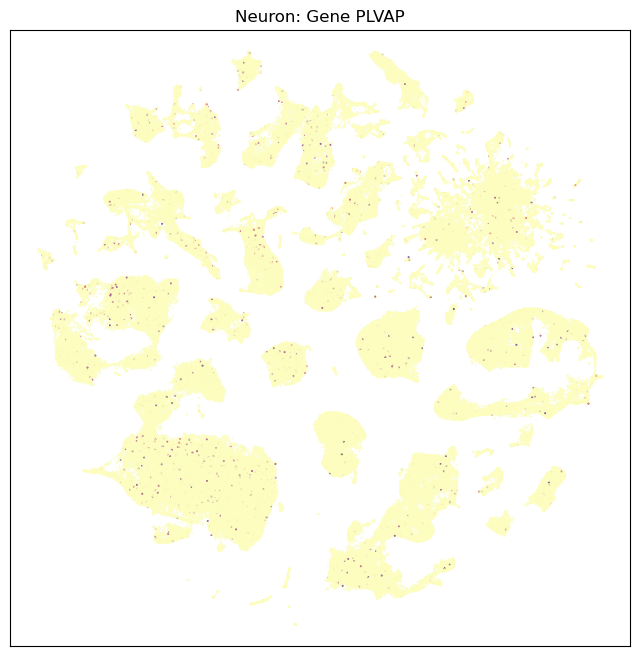

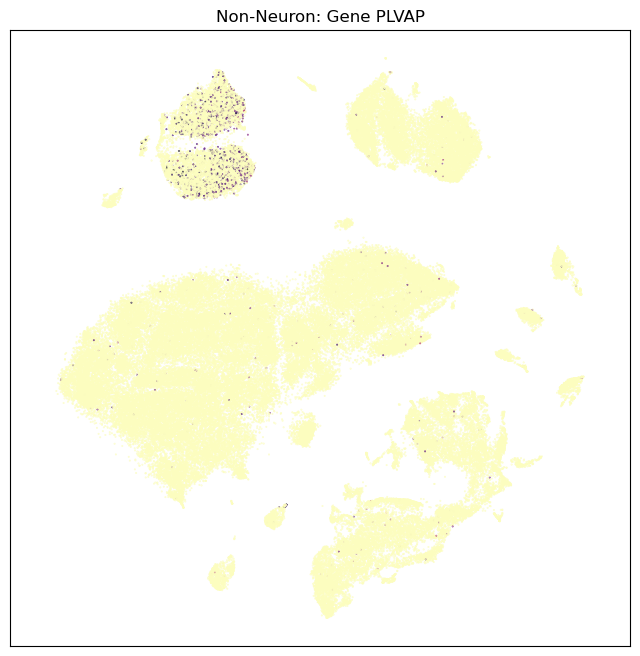

In [16]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['PLVAP'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene PLVAP")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['PLVAP'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene PLVAP")

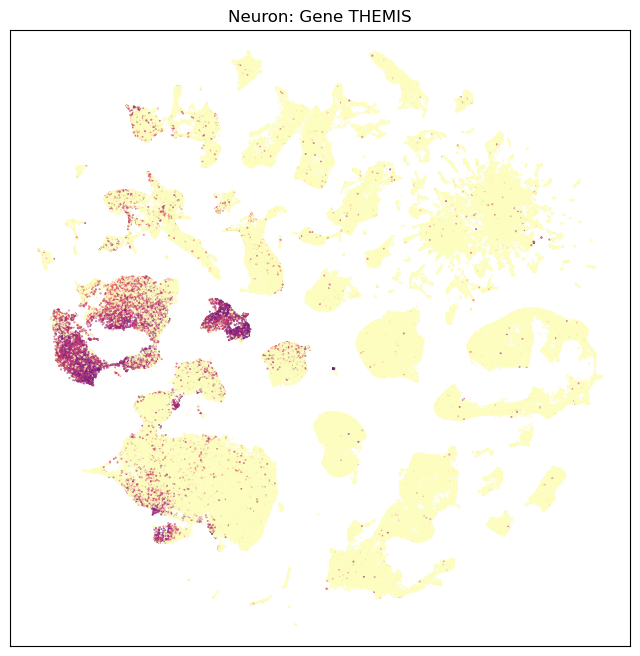

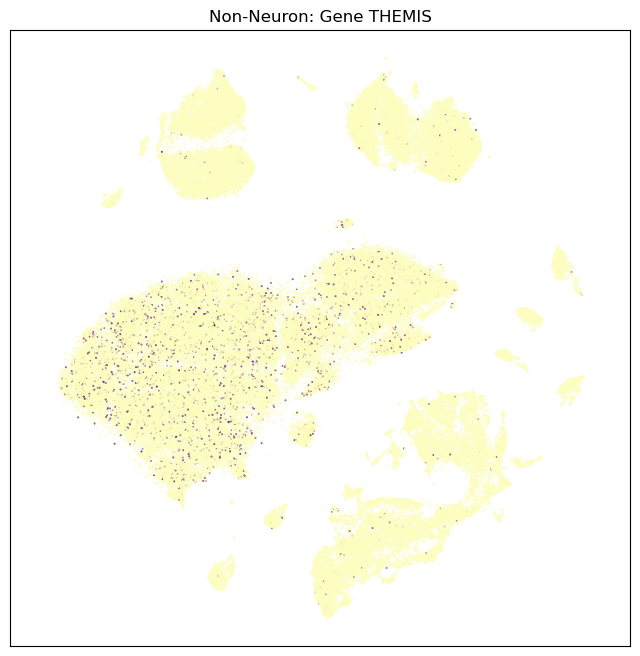

In [17]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['THEMIS'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene THEMIS")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['THEMIS'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene THEMIS")

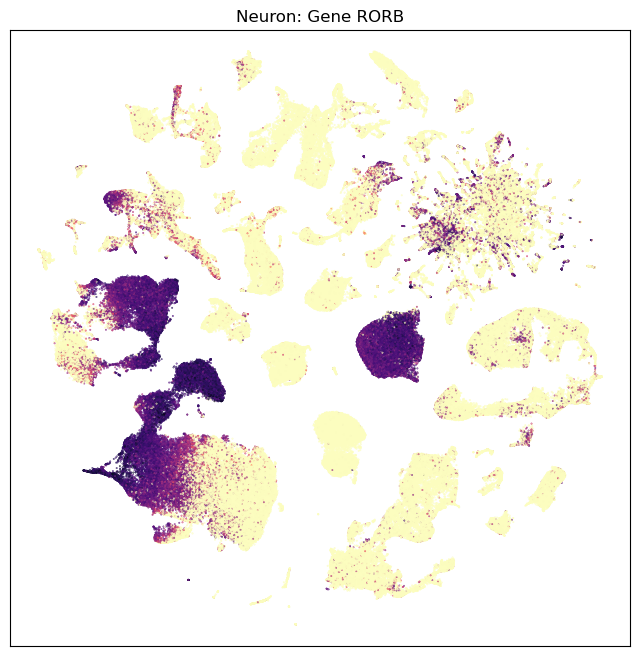

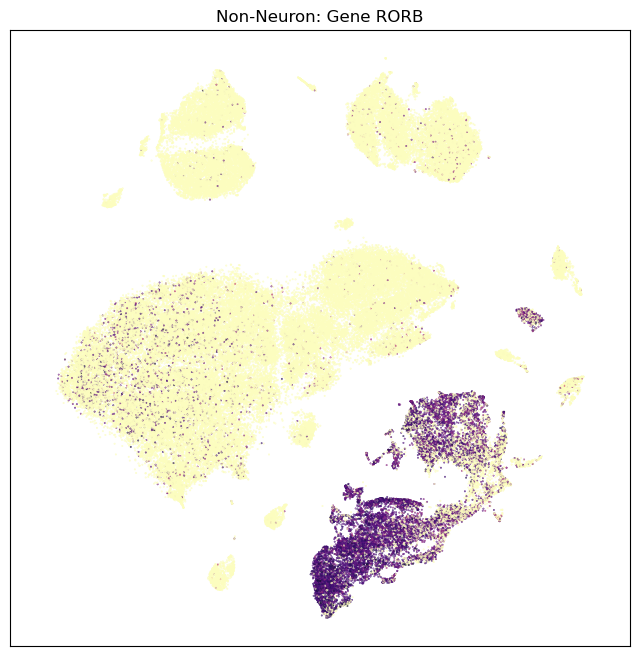

In [18]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['RORB'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron: Gene RORB")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['RORB'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron: Gene RORB")